In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [4]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [5]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [6]:
# Bakchodi Normalization
network_input=network_input.cpu().numpy().tolist()
for i in range(len(network_input)):
    for j in range(len(network_input[i])):
        network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
network_input=torch.Tensor(network_input).cuda()

In [7]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [8]:
network_output.shape

torch.Size([1829])

In [9]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0.5618, device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [10]:
network_input.shape

torch.Size([1829, 50, 1])

In [11]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [12]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [13]:
#network_input[0]

In [14]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.5)
        
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x, hidden,batch_size):
        
        output, hidden = self.lstm(x, hidden)        
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, self.hidden_size)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
          weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
        return hidden

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [15]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [16]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [17]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [19]:
epochs = 700
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        h = tuple([each.data for each in hidden])
        

        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h,train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h = tuple([each.data for each in hidden])
        
        output, hidden = model.forward(inputs, val_h,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-256-backchodi_norm_backchodi.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.2930876 	Val Loss:3.0980298 	Train Acc: 5.277778% 	Val Acc: 8.8888892%
Validation Loss decreased from    inf to 3.098030, saving the model weights
Epoch: 1	Train Loss: 3.2798521 	Val Loss:3.1138991 	Train Acc: 6.736111% 	Val Acc: 8.8888892%
Epoch: 2	Train Loss: 3.2821612 	Val Loss:3.1210028 	Train Acc: 4.513889% 	Val Acc: 8.8888892%
Epoch: 3	Train Loss: 3.2826431 	Val Loss:3.1258677 	Train Acc: 5.833334% 	Val Acc: 8.8888892%
Epoch: 4	Train Loss: 3.2856224 	Val Loss:3.1293614 	Train Acc: 6.597222% 	Val Acc: 8.8888892%
Epoch: 5	Train Loss: 3.2802803 	Val Loss:3.1325828 	Train Acc: 6.041667% 	Val Acc: 8.8888892%
Epoch: 6	Train Loss: 3.2804060 	Val Loss:3.1328339 	Train Acc: 6.527778% 	Val Acc: 8.8888892%
Epoch: 7	Train Loss: 3.2828621 	Val Loss:3.1350965 	Train Acc: 6.458334% 	Val Acc: 8.8888892%
Epoch: 8	Train Loss: 3.2827496 	Val Loss:3.1354113 	Train Acc: 6.25% 	Val Acc: 8.8888892%
Epoch: 9	Train Loss: 3.2867774 	Val Loss:3.1342693 	Train Acc: 5.625% 	Val Acc: 8.

Epoch: 86	Train Loss: 3.2767020 	Val Loss:3.1345695 	Train Acc: 6.597222% 	Val Acc: 8.6111114%
Epoch: 87	Train Loss: 3.2685553 	Val Loss:3.1290601 	Train Acc: 6.527778% 	Val Acc: 8.8888892%
Epoch: 88	Train Loss: 3.2705478 	Val Loss:3.1293744 	Train Acc: 6.458334% 	Val Acc: 8.8888892%
Epoch: 89	Train Loss: 3.2723439 	Val Loss:3.1324963 	Train Acc: 6.388889% 	Val Acc: 8.8888892%
Epoch: 90	Train Loss: 3.2732308 	Val Loss:3.1290101 	Train Acc: 6.527778% 	Val Acc: 8.8888892%
Epoch: 91	Train Loss: 3.2702609 	Val Loss:3.1279799 	Train Acc: 6.388889% 	Val Acc: 8.8888892%
Epoch: 92	Train Loss: 3.2714054 	Val Loss:3.1676039 	Train Acc: 6.527778% 	Val Acc: 8.0555558%
Epoch: 93	Train Loss: 3.2729525 	Val Loss:3.1414162 	Train Acc: 6.527778% 	Val Acc: 8.3333336%
Epoch: 94	Train Loss: 3.2756876 	Val Loss:3.1345781 	Train Acc: 6.319445% 	Val Acc: 8.8888892%
Epoch: 95	Train Loss: 3.2758311 	Val Loss:3.1322343 	Train Acc: 6.319445% 	Val Acc: 8.8888892%
Epoch: 96	Train Loss: 3.2725111 	Val Loss:3.130018

Epoch: 157	Train Loss: 2.6098593 	Val Loss:2.4418636 	Train Acc: 17.98611% 	Val Acc: 18.6111115%
Epoch: 158	Train Loss: 2.6176571 	Val Loss:2.6908617 	Train Acc: 19.09722% 	Val Acc: 18.3333339%
Epoch: 159	Train Loss: 2.6837147 	Val Loss:2.6226920 	Train Acc: 16.52778% 	Val Acc: 15.0000005%
Epoch: 160	Train Loss: 2.6019621 	Val Loss:2.5154458 	Train Acc: 19.30556% 	Val Acc: 19.7222231%
Epoch: 161	Train Loss: 2.5914048 	Val Loss:2.4032666 	Train Acc: 18.88889% 	Val Acc: 25.0000009%
Epoch: 162	Train Loss: 2.5829833 	Val Loss:2.3809976 	Train Acc: 21.94445% 	Val Acc: 28.8888895%
Validation Loss decreased from 2.389306 to 2.380998, saving the model weights
Epoch: 163	Train Loss: 2.5069104 	Val Loss:2.5237178 	Train Acc: 23.54167% 	Val Acc: 23.3333337%
Epoch: 164	Train Loss: 2.5640986 	Val Loss:2.2572824 	Train Acc: 21.59722% 	Val Acc: 32.5000008%
Validation Loss decreased from 2.380998 to 2.257282, saving the model weights
Epoch: 165	Train Loss: 2.3988116 	Val Loss:2.1820276 	Train Acc: 26.

Epoch: 221	Train Loss: 1.1187564 	Val Loss:0.6016716 	Train Acc: 65.34722% 	Val Acc: 82.7777781%
Epoch: 222	Train Loss: 1.1452157 	Val Loss:0.4882752 	Train Acc: 65.83333% 	Val Acc: 85.5555544%
Epoch: 223	Train Loss: 2.4979372 	Val Loss:1.5162168 	Train Acc: 36.04167% 	Val Acc: 55.0000003%
Epoch: 224	Train Loss: 1.6543364 	Val Loss:0.9142478 	Train Acc: 50.625% 	Val Acc: 69.1666678%
Epoch: 225	Train Loss: 1.2134792 	Val Loss:0.5000617 	Train Acc: 62.56944% 	Val Acc: 88.6111105%
Epoch: 226	Train Loss: 1.1784262 	Val Loss:0.4310503 	Train Acc: 65.13889% 	Val Acc: 89.7222216%
Validation Loss decreased from 0.470875 to 0.431050, saving the model weights
Epoch: 227	Train Loss: 1.0487335 	Val Loss:0.4862075 	Train Acc: 68.125% 	Val Acc: 84.7222224%
Epoch: 228	Train Loss: 1.0246075 	Val Loss:0.5083781 	Train Acc: 67.91667% 	Val Acc: 84.9999999%
Epoch: 229	Train Loss: 1.1086785 	Val Loss:0.4652332 	Train Acc: 65.83333% 	Val Acc: 86.9444445%
Epoch: 230	Train Loss: 1.1432588 	Val Loss:0.7771252 

Epoch: 286	Train Loss: 0.3066932 	Val Loss:0.1561709 	Train Acc: 90.76389% 	Val Acc: 94.1666648%
Epoch: 287	Train Loss: 0.2688618 	Val Loss:0.1392710 	Train Acc: 92.08333% 	Val Acc: 96.1111103%
Epoch: 288	Train Loss: 0.2766439 	Val Loss:0.1805360 	Train Acc: 91.31944% 	Val Acc: 96.1111108%
Epoch: 289	Train Loss: 0.2149386 	Val Loss:0.0969431 	Train Acc: 94.09722% 	Val Acc: 96.6666664%
Epoch: 290	Train Loss: 0.1762203 	Val Loss:0.0873026 	Train Acc: 95.27778% 	Val Acc: 97.4999989%
Epoch: 291	Train Loss: 0.1739762 	Val Loss:0.0695700 	Train Acc: 95.13889% 	Val Acc: 96.6666659%
Epoch: 292	Train Loss: 0.1498915 	Val Loss:0.0471485 	Train Acc: 96.25% 	Val Acc: 98.6111100%
Validation Loss decreased from 0.059427 to 0.047148, saving the model weights
Epoch: 293	Train Loss: 0.1354194 	Val Loss:0.0527716 	Train Acc: 96.11111% 	Val Acc: 98.0555554%
Epoch: 294	Train Loss: 0.1480377 	Val Loss:0.0756130 	Train Acc: 96.11111% 	Val Acc: 97.2222214%
Epoch: 295	Train Loss: 0.1458389 	Val Loss:0.1124228

Epoch: 365	Train Loss: 0.0776648 	Val Loss:0.0765766 	Train Acc: 97.77778% 	Val Acc: 97.4999994%
Epoch: 366	Train Loss: 0.0645778 	Val Loss:0.0220597 	Train Acc: 98.05556% 	Val Acc: 99.7222220%
Epoch: 367	Train Loss: 0.0483639 	Val Loss:0.0209942 	Train Acc: 99.02778% 	Val Acc: 99.1666665%
Epoch: 368	Train Loss: 0.0522044 	Val Loss:0.0247668 	Train Acc: 98.54167% 	Val Acc: 98.6111109%
Epoch: 369	Train Loss: 0.0558711 	Val Loss:0.0162071 	Train Acc: 98.33333% 	Val Acc: 99.4444445%
Validation Loss decreased from 0.019944 to 0.016207, saving the model weights
Epoch: 370	Train Loss: 0.0390347 	Val Loss:0.0166174 	Train Acc: 98.81944% 	Val Acc: 99.4444445%
Epoch: 371	Train Loss: 0.0543187 	Val Loss:0.0650820 	Train Acc: 98.61111% 	Val Acc: 98.0555554%
Epoch: 372	Train Loss: 0.0847899 	Val Loss:0.0363553 	Train Acc: 98.125% 	Val Acc: 98.3333334%
Epoch: 373	Train Loss: 0.0683894 	Val Loss:0.0439660 	Train Acc: 98.26389% 	Val Acc: 98.3333329%
Epoch: 374	Train Loss: 0.0568337 	Val Loss:0.137300

Epoch: 446	Train Loss: 0.0389363 	Val Loss:0.0140887 	Train Acc: 99.23611% 	Val Acc: 99.4444440%
Epoch: 447	Train Loss: 0.0275320 	Val Loss:0.0144806 	Train Acc: 99.375% 	Val Acc: 99.4444440%
Epoch: 448	Train Loss: 0.0345939 	Val Loss:0.0149435 	Train Acc: 99.16667% 	Val Acc: 99.4444440%
Epoch: 449	Train Loss: 0.0292394 	Val Loss:0.0210241 	Train Acc: 99.375% 	Val Acc: 99.1666665%
Epoch: 450	Train Loss: 0.0430808 	Val Loss:0.0167051 	Train Acc: 98.95833% 	Val Acc: 99.4444445%
Epoch: 451	Train Loss: 0.0368755 	Val Loss:0.0193786 	Train Acc: 98.95833% 	Val Acc: 99.1666665%
Epoch: 452	Train Loss: 0.0581001 	Val Loss:0.0144232 	Train Acc: 98.19444% 	Val Acc: 99.4444440%
Epoch: 453	Train Loss: 0.0374315 	Val Loss:0.0294444 	Train Acc: 98.95833% 	Val Acc: 98.6111109%
Epoch: 454	Train Loss: 0.0732547 	Val Loss:0.0550085 	Train Acc: 97.98611% 	Val Acc: 97.7777779%
Epoch: 455	Train Loss: 0.0645306 	Val Loss:0.0621489 	Train Acc: 98.19444% 	Val Acc: 97.7777779%
Epoch: 456	Train Loss: 0.0480595 	

Epoch: 529	Train Loss: 0.0327546 	Val Loss:0.0136557 	Train Acc: 99.23611% 	Val Acc: 99.1666665%
Epoch: 530	Train Loss: 0.0317369 	Val Loss:0.0122903 	Train Acc: 99.375% 	Val Acc: 99.4444440%
Epoch: 531	Train Loss: 0.0327754 	Val Loss:0.0124582 	Train Acc: 99.16667% 	Val Acc: 99.1666665%
Epoch: 532	Train Loss: 0.0294759 	Val Loss:0.0135640 	Train Acc: 99.44444% 	Val Acc: 99.1666665%
Epoch: 533	Train Loss: 0.0284829 	Val Loss:0.0119519 	Train Acc: 99.30556% 	Val Acc: 99.4444440%
Epoch: 534	Train Loss: 0.0350507 	Val Loss:0.0282782 	Train Acc: 98.88889% 	Val Acc: 98.8888885%
Epoch: 535	Train Loss: 0.0468049 	Val Loss:0.0252706 	Train Acc: 98.54167% 	Val Acc: 98.3333329%
Epoch: 536	Train Loss: 0.0770894 	Val Loss:0.0365427 	Train Acc: 97.84722% 	Val Acc: 98.8888890%
Epoch: 537	Train Loss: 0.0496450 	Val Loss:0.0174771 	Train Acc: 98.47222% 	Val Acc: 99.1666660%
Epoch: 538	Train Loss: 0.0412019 	Val Loss:0.0129036 	Train Acc: 98.81944% 	Val Acc: 99.4444440%
Epoch: 539	Train Loss: 0.0355603

Epoch: 608	Train Loss: 0.0196691 	Val Loss:0.0128409 	Train Acc: 99.375% 	Val Acc: 99.1666665%
Epoch: 609	Train Loss: 0.0196393 	Val Loss:0.0126868 	Train Acc: 99.30556% 	Val Acc: 99.1666665%
Epoch: 610	Train Loss: 0.0225215 	Val Loss:0.0110868 	Train Acc: 99.30556% 	Val Acc: 99.4444440%
Epoch: 611	Train Loss: 0.0216522 	Val Loss:0.0113922 	Train Acc: 99.23611% 	Val Acc: 99.4444440%
Epoch: 612	Train Loss: 0.0195597 	Val Loss:0.0123586 	Train Acc: 99.44444% 	Val Acc: 99.1666665%
Epoch: 613	Train Loss: 0.0186024 	Val Loss:0.0124807 	Train Acc: 99.375% 	Val Acc: 99.1666665%
Epoch: 614	Train Loss: 0.0279369 	Val Loss:0.0474658 	Train Acc: 99.02778% 	Val Acc: 98.3333329%
Epoch: 615	Train Loss: 0.0221653 	Val Loss:0.0119070 	Train Acc: 99.16667% 	Val Acc: 99.1666660%
Epoch: 616	Train Loss: 0.0212494 	Val Loss:0.0111247 	Train Acc: 99.23611% 	Val Acc: 99.4444440%
Epoch: 617	Train Loss: 0.0263464 	Val Loss:0.0335954 	Train Acc: 99.09722% 	Val Acc: 98.3333329%
Epoch: 618	Train Loss: 0.0403540 	

Epoch: 689	Train Loss: 0.0258618 	Val Loss:0.0105646 	Train Acc: 99.30556% 	Val Acc: 99.4444440%
Validation Loss decreased from 0.010623 to 0.010565, saving the model weights
Epoch: 690	Train Loss: 0.0252426 	Val Loss:0.0105898 	Train Acc: 99.44444% 	Val Acc: 99.4444445%
Epoch: 691	Train Loss: 0.0201018 	Val Loss:0.0110136 	Train Acc: 99.30556% 	Val Acc: 99.4444440%
Epoch: 692	Train Loss: 0.0245884 	Val Loss:0.0122487 	Train Acc: 99.44444% 	Val Acc: 99.1666665%
Epoch: 693	Train Loss: 0.0210516 	Val Loss:0.0108394 	Train Acc: 99.30556% 	Val Acc: 99.1666665%
Epoch: 694	Train Loss: 0.0216377 	Val Loss:0.0104543 	Train Acc: 99.44444% 	Val Acc: 99.4444445%
Validation Loss decreased from 0.010565 to 0.010454, saving the model weights
Epoch: 695	Train Loss: 0.0312073 	Val Loss:0.0108102 	Train Acc: 99.09722% 	Val Acc: 99.4444445%
Epoch: 696	Train Loss: 0.0220826 	Val Loss:0.0103492 	Train Acc: 99.30556% 	Val Acc: 99.4444440%
Validation Loss decreased from 0.010454 to 0.010349, saving the mode

#### Music Genaration


In [20]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256-256-backchodi_norm_backchodi.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [102]:
#load population database
testing_data = np.ones(200)*0.57
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data_rev.extend(testing_data_rev)
# testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [89]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    #list1[i]=(list1[i]-50)/(89-50)
    list1[i]=(list1[i])/(89)


list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [90]:
#testing_data

In [103]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    test_hidden = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        h = tuple([each.data for each in test_hidden])
        
        test_output,_ = test_model.forward(test_slice, h, test_batch_size)
        test_output = F.softmax(test_output, dim = 1)
    
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [104]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [105]:
#predicted_notes_lst

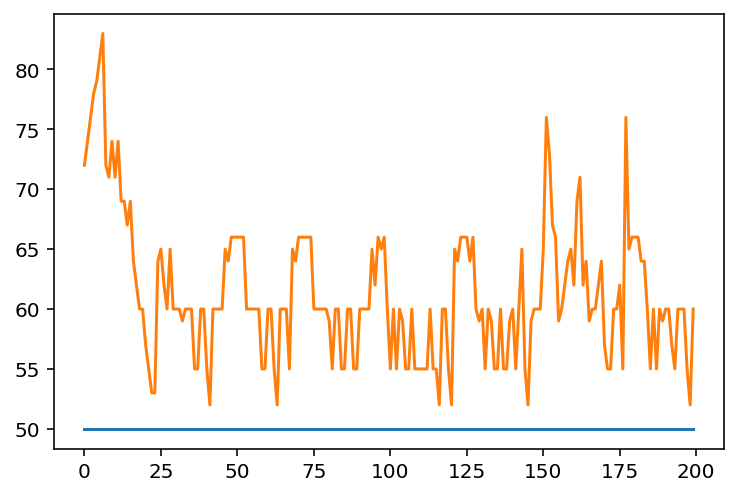

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*89))

plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
#plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [50]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 13,
         74: 10,
         76: 7,
         78: 4,
         79: 5,
         81: 10,
         83: 20,
         71: 7,
         69: 9,
         73: 5,
         84: 12,
         86: 1,
         77: 5,
         67: 10,
         62: 12,
         66: 12,
         75: 6,
         70: 7,
         60: 31,
         65: 15,
         64: 8,
         57: 1,
         55: 13,
         59: 8,
         52: 2,
         68: 7})